In [49]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]=''

import tensorflow as tf
import numpy as np
import numpy.random as rng
from data_loader.data_generator import MNISTDataGenerator, LinearDataGenerator
from models.npmodels import NPModel4,DirectNPModel4,AENPModel,AEDFANPModel
from trainers.sf_trainer import SFTrainer, AESFTrainer
from utils.config import process_config
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random
import operator
from utils.utils import tf_matmul_r, tf_matmul_l, tf_eigvecs, tf_eigvals

import itertools

import plotly
import plotly.graph_objs as go


In [50]:
# inshape=30
# hidden=20
# outshape=10
batch_size=50
# T = rng.randn(outshape, inshape)
def traindata(batch_size):
    train_x=np.zeros((batch_size,2))
    train_y=np.zeros((batch_size))
    for i in range(batch_size):
        inp=np.random.randint(0,2,size=[1,2])
        output=operator.xor(inp[0,0],inp[0,1])
        train_x[i,:]=inp
        train_y[i]=output
    return (train_x, train_y)

In [51]:
#p = self.config.state_size[0]
p=2# inshape 
m =10# hiddenshap
j = 1#outshpae
#n = 10
var_xi = 0.01
# learning_rate=0
# lmda_learning_rate=1e-5
#lmda_learning_rate=0

#Training data inputs
x=tf.placeholder(tf.float32,[None,p], name = 'x')
y=tf.placeholder(tf.float32,[None,j], name = 'y')
learning_rate=tf.placeholder(tf.float32,[None],name='learning_rate')
lmda_learning_rate=tf.placeholder(tf.float32,[None],name='lmda_learning_rate')

#Scale weight initialization
alpha0 = np.sqrt(2.0/p)
alpha1 = np.sqrt(2.0/m)
alpha2 = np.sqrt(2.0/j)
alpha3 = 1

A = tf.Variable(rng.randn(p+1,m)*alpha0, name="hidden_weights", dtype=tf.float32)
W = tf.Variable(rng.randn(m+1,j)*alpha1, name="output_weights", dtype=tf.float32)
B = tf.Variable(rng.randn(m+1,j)*alpha2, name="feedback_weights", dtype=tf.float32)

# network architecture with ones added for bias terms
e0 = tf.ones([tf.shape(x)[0], 1], tf.float32)
e1 = tf.ones([tf.shape(x)[0], 1], tf.float32)
x_aug = tf.concat([x, e0], 1)
h = tf.sigmoid(tf.matmul(x_aug, A))
#Make some noise
h_aug = tf.concat([h, e1], 1)
xi = tf.random_normal(shape=tf.shape(h_aug), mean=0.0, stddev=var_xi, dtype=tf.float32)
h_tilde = h_aug + xi
#Add noise to hidden layer
y_p = tf.matmul(h_tilde, W)
y_p_0 = tf.matmul(h_aug, W)

trainable = [A, W, B]


In [52]:
#mean squared error
loss = tf.reduce_sum(tf.pow(y_p-y, 2))/2
loss_0 = tf.reduce_sum(tf.pow(y_p_0-y, 2))/2
e = (y_p - y)
h_prime = tf.multiply(h_tilde, 1-h_tilde)[:,0:m]

#Feedback data for saving
#Only take first item in epoch
delta_bp = tf.matmul(e, tf.transpose(W[0:m,:]))[0,:]
delta_fa = tf.matmul(e, tf.transpose(B[0:m,:]))[0,:]
norm_W = tf.norm(W)
norm_B = tf.norm(B)
error_FA = tf.norm(delta_bp - delta_fa)
alignment = tf.reduce_sum(tf.multiply(delta_fa,delta_bp))/tf.norm(delta_fa)/tf.norm(delta_bp)
norm_diff = tf.norm(W - B)
eigs = tf_eigvals(tf.matmul(tf.transpose(B), W))

#Compute updates for W and A (based on B)
lmda = tf.matmul(e, tf.transpose(B[0:m,:]))
grad_W = tf.gradients(xs=W, ys=loss)[0]
grad_A = tf.matmul(tf.transpose(x_aug), tf.multiply(h_prime, lmda))
grad_B = tf.matmul(tf.matmul(B, tf.transpose(e)) - tf.transpose(xi)*(loss - loss_0)/var_xi, e)

new_W = W.assign(W - learning_rate*grad_W)
new_A = A.assign(A - learning_rate*grad_A)            
new_B = B.assign(B - lmda_learning_rate*grad_B)
train_step = [new_W, new_A, new_B]


# correct_prediction = tf.equal(tf.argmax(y_p, 1), tf.argmax(y, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# #Also need to add eigenvector stuff
# training_metrics = [alignment, norm_W, norm_B, error_FA, eigs[0]]

In [53]:
eta_1=np.zeros(7)
eta_1[1::]=np.logspace(-3,-6,6)
eta_1

array([0.00000000e+00, 1.00000000e-03, 2.51188643e-04, 6.30957344e-05,
       1.58489319e-05, 3.98107171e-06, 1.00000000e-06])

In [54]:
init = tf.global_variables_initializer()

store_out=dict()

eta_1=np.zeros(7)
eta_1[1::]=np.logspace(-3,-6,6)

eta_lmda=np.zeros(7)
eta_lmda[1::]=np.logspace(-2,-6,6)

combo=list(itertools.product(np.sort(eta_1[::-1]),np.sort(eta_lmda[::-1])))

iteration=20000
store_al=np.zeros([len(combo),iteration])
store_df=np.zeros([len(combo),iteration])
# store_err=[[] for i in range(len(combo))]
store_err=np.zeros([len(combo),iteration])
non_converge=[]
accuracy=np.zeros([len(combo),iteration])
x_in=[[0,0],[0,1],[1,0],[1,1]]
with tf.Session() as sess:
    for i in range(len(combo)):
        store_out[combo[i]]=np.zeros((iteration,4))
        sess.run(init)
        print("Present combo:",i+1)
        print("Present learning rate:",combo[i][0])
        learning_rate1=[combo[i][0]]
        lmda_learning_rate1=[combo[i][1]]
        print("Present lmda learning rate:",combo[i][1])  
        flag=0
        for idx in range(iteration):
            (train_x, train_y) = traindata(batch_size)
            train_x=np.float32(train_x)
            train_y=(np.float32(train_y))
            train_y=train_y.reshape((batch_size,1))#to make it [50,1] instead of [50,]
            _,align,diff,err=sess.run([train_step,alignment,norm_diff,loss_0],feed_dict={x: train_x, y: train_y,
                                                                                        learning_rate:learning_rate1,
                                                                                   lmda_learning_rate:lmda_learning_rate1})
            out=sess.run([y_p],feed_dict={x: x_in})
            if flag==0:
                if np.isnan(err)==True:
                    print("\n\tModel does not converge!!!\n")
                    non_converge.append(i)
                    flag=1
                    break
#             err_per=np.sum(np.abs(train_y-np.round(abs(out))))/batch_size      
#             accuracy[i,idx]=(err_per)
            store_al[i,idx]=align
            store_df[i,idx]=diff
#             store_err[i].append(err)
            store_out[combo[i]][idx,:]=out[0][:,0]
            
            store_err[i,idx]=err
#             if (idx+1)%500==0:
#                 print("Iteration count:",idx+1)

# for rem in non_converge:
#     del store_err[rem]    

Present combo: 1
Present learning rate: 0.0
Present lmda learning rate: 0.0
Present combo: 2
Present learning rate: 0.0
Present lmda learning rate: 1e-06
Present combo: 3
Present learning rate: 0.0
Present lmda learning rate: 0.0001
Present combo: 4
Present learning rate: 0.0
Present lmda learning rate: 0.01
Present combo: 5
Present learning rate: 1e-06
Present lmda learning rate: 0.0
Present combo: 6
Present learning rate: 1e-06
Present lmda learning rate: 1e-06
Present combo: 7
Present learning rate: 1e-06
Present lmda learning rate: 0.0001
Present combo: 8
Present learning rate: 1e-06
Present lmda learning rate: 0.01
Present combo: 9
Present learning rate: 3.1622776601683795e-05
Present lmda learning rate: 0.0
Present combo: 10
Present learning rate: 3.1622776601683795e-05
Present lmda learning rate: 1e-06
Present combo: 11
Present learning rate: 3.1622776601683795e-05
Present lmda learning rate: 0.0001
Present combo: 12
Present learning rate: 3.1622776601683795e-05
Present lmda lea

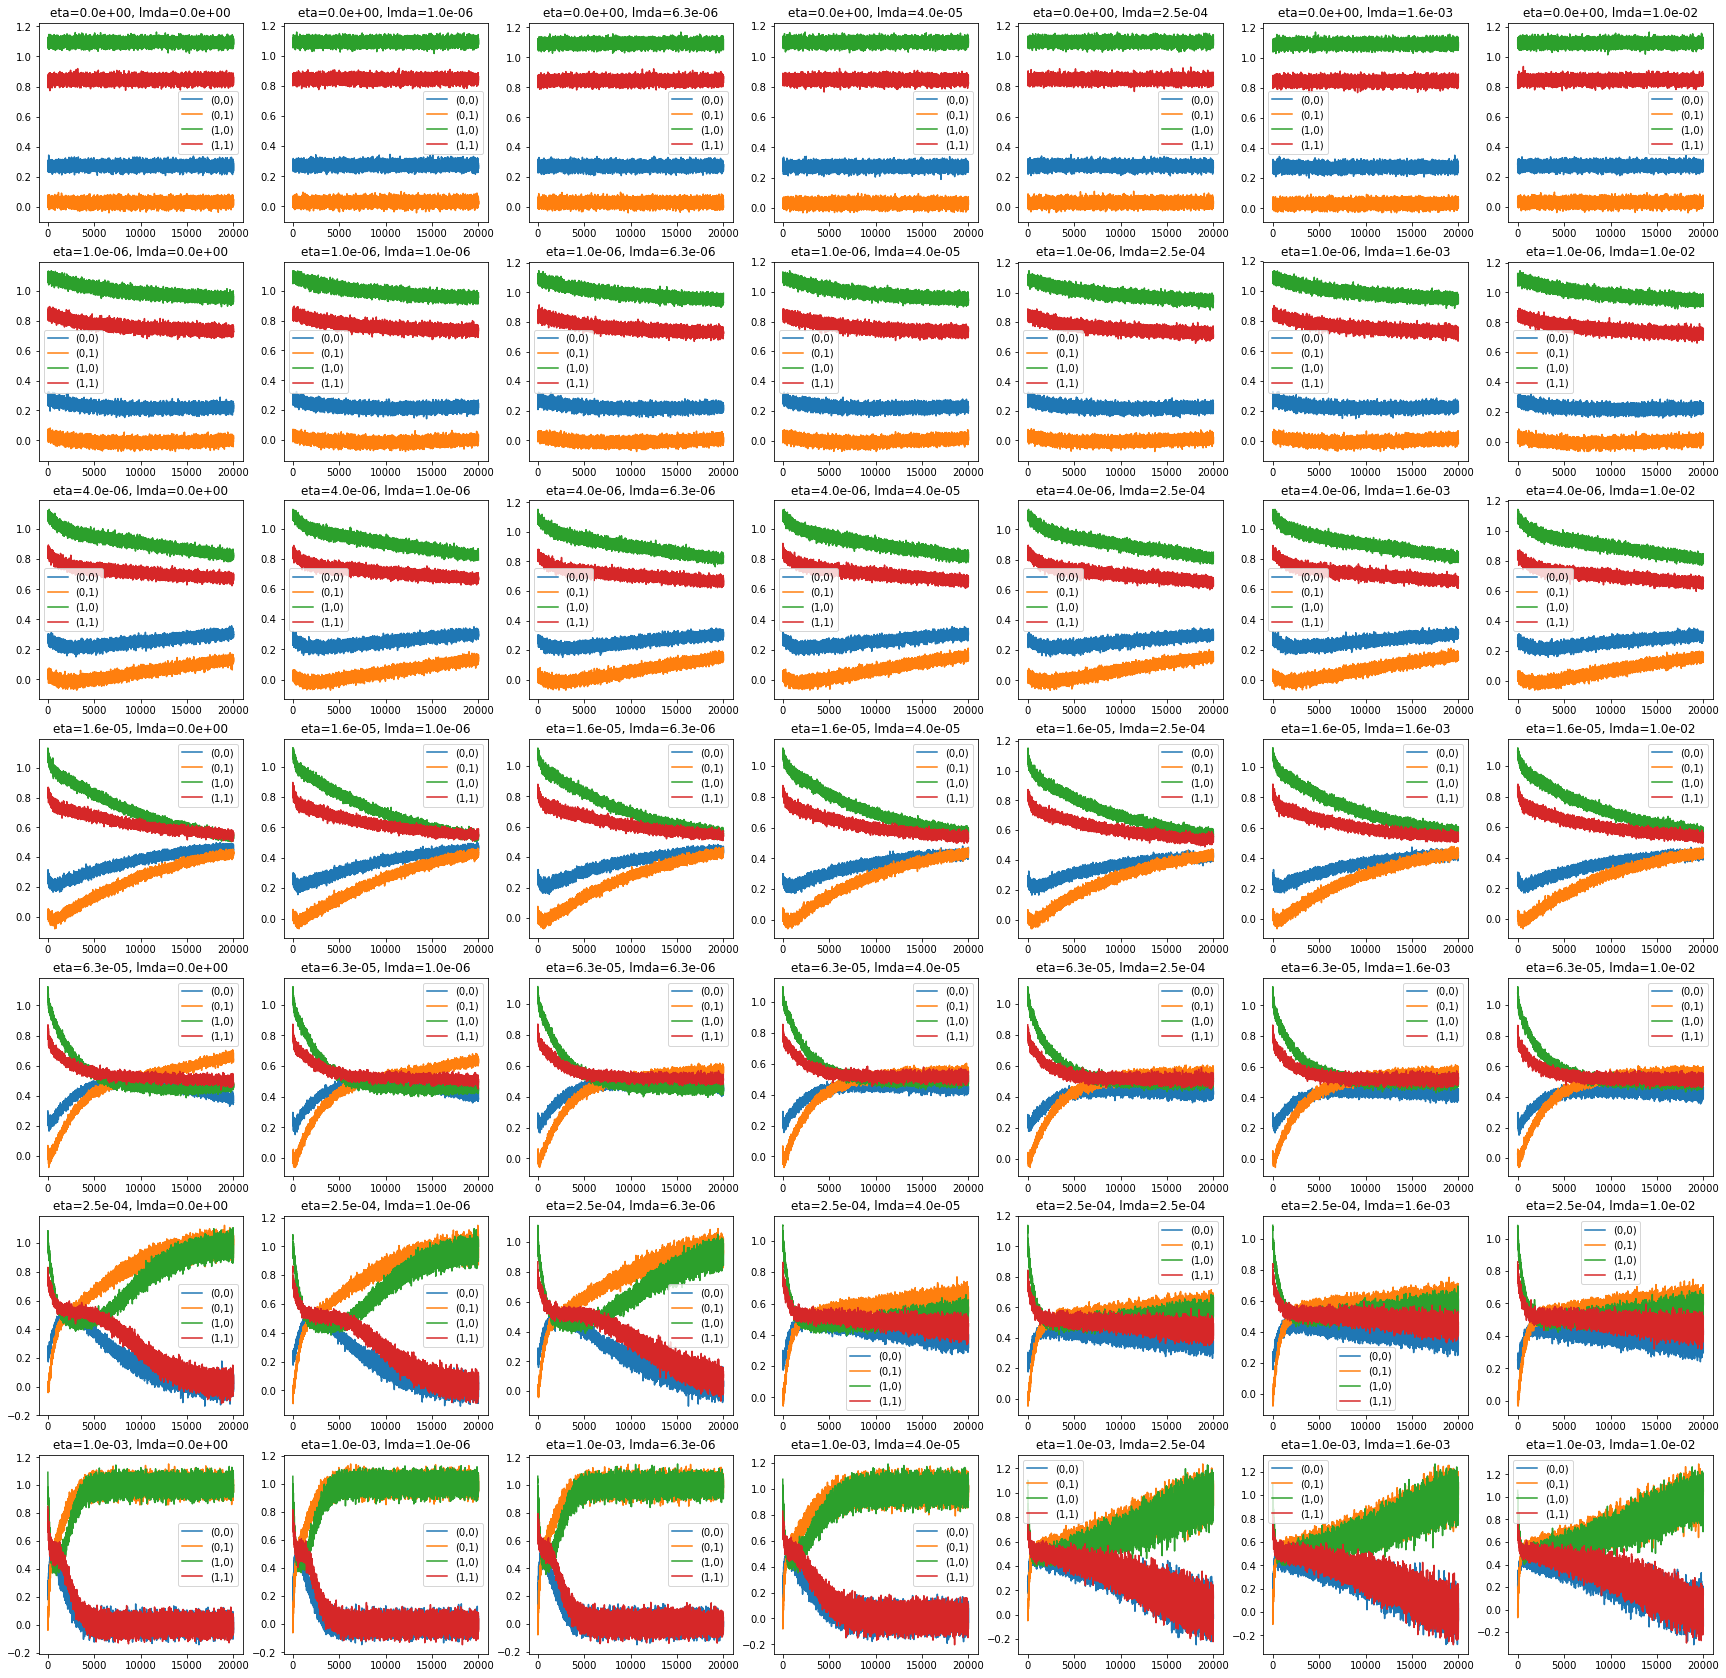

In [11]:
from pylab import *
plt.figure(figsize=(30,30))
for i in range(len(combo)):
    subplot(eta_1.shape[0],eta_lmda.shape[0],i+1)
    plt.plot(range(iteration), store_out[combo[i]])
    plt.legend(['(0,0)','(0,1)','(1,0)','(1,1)'])
    head="eta=%0.1e, lmda=%0.1e"%(combo[i][0],combo[i][1])
    plt.title(head)
plt.show()





In [12]:
store_err_s=[]
store_al_s=[]
store_df_s=[]
print("Following indexes did not converge",non_converge)
for count in range(store_err.shape[0]):
    if count in non_converge:
        print("removing row:",count)
    else:
        store_err_s.append(store_err[count,:]) 
#         store_al_s.append(store_al[count,:])


store_err_s=np.array(store_err_s)

for val in sorted(non_converge,reverse=True):
    del combo[val]
eta_1new=[]
eta_lmdanew=[]
for first,second in combo:
    if first not in eta_1new:
        eta_1new.append(first)
    if second not in eta_lmdanew:
        eta_lmdanew.append(second)
eta_1new=np.array(eta_1new)
eta_lmdanew=np.array(eta_lmdanew)


Following indexes did not converge []


In [31]:
combo=list(itertools.product(np.sort(eta_1[::-1]),np.sort(eta_lmda[::-1])))
temp=[i for i in range(16)]
np.flipud(np.reshape(temp,[4,4]))

array([[12, 13, 14, 15],
       [ 8,  9, 10, 11],
       [ 4,  5,  6,  7],
       [ 0,  1,  2,  3]])

In [41]:
#storing last values for error and reshaping into appropriate format
last_val=np.zeros([eta_1new.shape[0]*eta_lmdanew.shape[0],1])
for num in range(store_err_s.shape[0]):
    last_val[num]=store_err_s[num][-1]
reshape_err=np.flipud(np.reshape(last_val,[eta_1new.shape[0],eta_lmdanew.shape[0]]))
#reshape_err = np.reshape(last_val, [eta_1new.shape[0], eta_lmdanew.shape[0]]).T



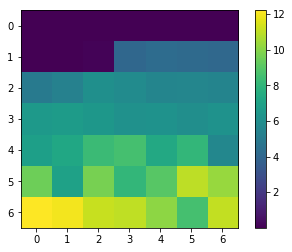

In [49]:
# print(combo)
# print(last_val)
var=(np.flipud(np.reshape(last_val,[eta_1new.shape[0],eta_lmdanew.shape[0]])))
plt.imshow(var)
plt.colorbar()
plt.show()

In [16]:
lf_df=np.zeros([eta_1.shape[0]*eta_lmda.shape[0],10]) #stores last 10 norm_dfs
mean_df=np.zeros([eta_1.shape[0]*eta_lmda.shape[0],1]) #stores mean of last 10 norm_dfs
for num in range(store_df.shape[0]):
    lf_df[num,:]=store_df[num,iteration-10:iteration]
    mean_df[num]=np.mean(store_df[num,iteration-10:iteration])
    
reshape_df=np.flipud(np.reshape(mean_df,[eta_1.shape[0],eta_lmda.shape[0]]))

In [17]:
last_al=np.zeros([eta_1.shape[0]*eta_lmda.shape[0],1])
for num2 in range(store_al.shape[0]):
    last_al[num2]=store_al[num2][-1]

reshape_al=np.flipud(np.reshape(last_al,[eta_1.shape[0],eta_lmda.shape[0]]))

In [18]:
eta_1new

array([0.00000000e+00, 1.00000000e-06, 3.98107171e-06, 1.58489319e-05,
       6.30957344e-05, 2.51188643e-04, 1.00000000e-03])

In [28]:
eta_xtick=np.sort(eta_1new)
for x in range(len(eta_1new)):
    eta_xtick[x]="%0.1e" % eta_xtick[x]
eta_ytick=np.sort(eta_lmdanew)
for y in range(len(eta_lmdanew)):
    eta_ytick[y]="%0.1e" % eta_ytick[y]

In [55]:
# a = np.array([[1,2], [3,4]])
# plt.imshow(a)
# plt.colorbar()
# plt.show()
ylabels

['', 0.0, 1e-06, 6.3e-06, 4e-05, 0.00025, 0.0016, 0.01, '']

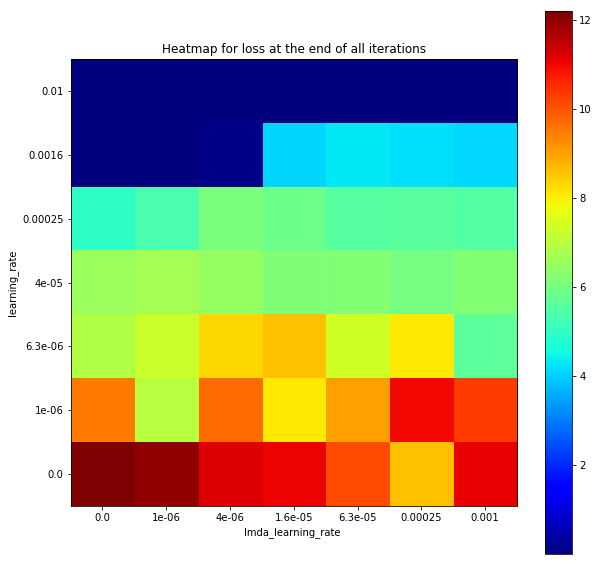

In [57]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
# plt.axes(xscale='log',yscale='log')
# ax.locator_params(axis='y',nbins=len(eta_ytick))
# ax.locator_params(axis='x',nbins=len(eta_xtick))
h=ax.imshow(reshape_err, cmap='jet',interpolation='none')
plt.colorbar(h,ax=ax)
xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels[1:8]=eta_xtick
ax.set_xticklabels(xlabels)
# ax.set_xticklabels([str(eta) for eta in eta_xtick])


ylabels = [item.get_text() for item in ax.get_yticklabels()]
ylabels[1:8]=eta_ytick
ax.set_yticklabels(ylabels[::-1])


# ax.set_xticks(strings)
# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 0.712123))
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.01e'))

ax.locator_params(axis='x',nbins=len(eta_xtick))
ax.locator_params(axis='y',nbins=len(eta_ytick))


# ax.set_ticks(eta_xtick)

ax.set_xlabel("lmda_learning_rate ")
ax.set_ylabel("learning_rate")
plt.title("Heatmap for loss at the end of all iterations")
plt.show()

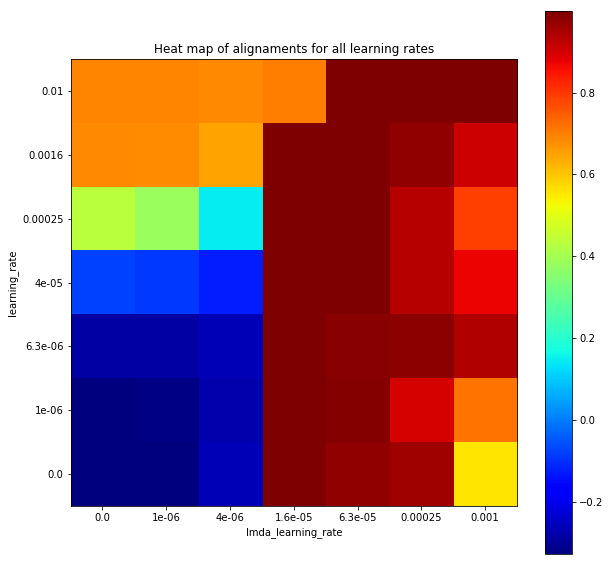

In [59]:
eta_xtick1=np.sort(eta_1)
for x in range(len(eta_1)):
    eta_xtick1[x]="%0.1e" % eta_xtick1[x]
eta_ytick1=np.sort(eta_lmda)
for y in range(len(eta_lmda)):
    eta_ytick1[y]="%0.1e" % eta_ytick1[y]
    
    
fig,ax=plt.subplots(1,1,figsize=(10,10))

h2=plt.imshow(reshape_al,cmap='jet')
plt.colorbar(h2,ax=ax)
ax.locator_params(axis='x',nbins=len(eta_xtick1))
ax.locator_params(axis='y',nbins=len(eta_ytick1))

xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels[1:8]=eta_xtick1
ax.set_xticklabels(xlabels)

ylabels = [item.get_text() for item in ax.get_yticklabels()]
ylabels[1:8]=eta_ytick1
ax.set_yticklabels(ylabels[::-1])


plt.title("Heat map of alignaments for all learning rates")
ax.set_xlabel("lmda_learning_rate")
ax.set_ylabel("learning_rate")
plt.show()

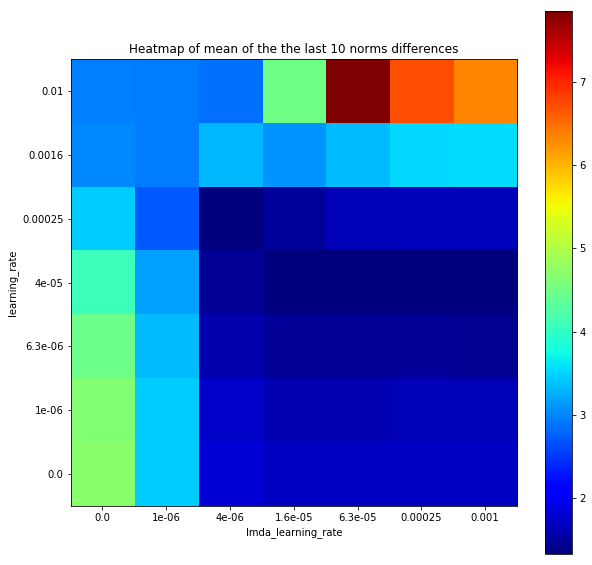

In [60]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
h3=plt.imshow(reshape_df,cmap='jet')
plt.colorbar(h3,ax=ax)


ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels[::-1])
ax.locator_params(axis='x',nbins=len(eta_xtick1))
ax.locator_params(axis='y',nbins=len(eta_ytick1))

plt.title("Heatmap of mean of the the last 10 norms differences")
plt.xlabel("lmda_learning_rate")
plt.ylabel("learning_rate")
plt.show()

# for iter in range(lf_df.shape[0]):
#     leg='Combination '+str(iter+1)
#     plt.plot(lf_df[iter,:],label=leg)
# plt.title("Last 10 norm fifferences for every combination of learnig rates")
# plt.legend()
# plt.show()           
    
# # fig, ax1 = plt.subplots(1,1)
# # data = np.random.randint(0, 100, size=(10, 10))
# # ax1.imshow(data, cmap='jet', interpolation='nearest')
# # ax1.set_xticklabels(['', 0,10,20,30,40])
# # plt.show()

In [23]:
# eta_xtick1=eta_1[::-1]
# for x in range(len(eta_1)):
#     eta_xtick1[x]="%0.1e" % eta_xtick[x]
# eta_ytick1=eta_lmda[::-1]
# for y in range(len(eta_lmda)):
#     eta_ytick1[y]="%0.1e" % eta_ytick[y]

    
# fig,ax=plt.subplots(1,1,figsize=(10,10))

# h2=plt.imshow(reshape_acc,cmap='jet',origin='lower')
# plt.colorbar(h2,ax=ax)
# ax.locator_params(axis='x',nbins=len(eta_xtick1))
# ax.locator_params(axis='y',nbins=len(eta_ytick1))
# ax.set_xticklabels([str(eta) for eta in eta_xtick1])
# ax.set_yticklabels([str(eta) for eta in eta_ytick1])


# plt.title("Heat map of errors for all learning rates")
# ax.set_xlabel("learning_rate")
# ax.set_ylabel("lmda_learning_rate")
# plt.show()

In [24]:
# # x=[i for i in range(iteration)]
# for i in range((accuracy.shape[0])):
#     leg='Combination '+str(i+1)
#     plt.plot(accuracy[i,:],label=leg)
# plt.legend()
# plt.show()